# Multimodal Learning Analytics

During this tutorial, we will explore the affordances that Multimodal Learning Analytics offer for the undestanding and improving of learning processes.  We will see different examples of video, audio and digital pen analysis.

The code used for these examples is beyond what is required in this course.  Focus on the capabilities and possibilities of the analysis more than in the actual implementation.

We will start by installing some libraries that we will use during the tutorial:
* OpenCV: provides functions for computer vision algorithms and image and video manipulation
* SpeechRecognition: provide functions to call speech recognition services in the cloud.

In [88]:
!pip install opencv-python
!pip install opencv-contrib-python
!pip install SpeechRecognition

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Tracking of an object in a video

The first example it is a common case in video analysis of a learning situation.  In this case, 3 students are collaboratively solving math and geometry problems.  To promote collaboration, just one calculator is in the table.  To analyze collaboration dynamics, we want to know, at each moment, which student is in "posession" of the calculator. 

This will be an easy, altough time consuming, task for a human being.  We are naturally trained to recognize objects in our environment and to track them.  For computers, there are several alternatives.  We will use the following methods:

- Recognize salient features in the image of the object that you want to search
- Recognize salient features in the image where you are searching the object
- Match those salient features based on their similarity.

Let's see how we do this in Python with the help of OpenCV

In [89]:
%matplotlib inline
import math
import numpy as np
import cv2
from matplotlib import pyplot as plt

<font color="darkblue">**Explanation:**
<ul>
<li>We load the following libraries:
<li>math:  for mathematical calculation of angles 
<li>numpy: for storing images as arrays
<li>cv2: the OpenCV libarary.  It provides all the Computer Vision functions
<li>matplotlib: to be able to show the images.
</ul>
</font>

First we load the image of the calculator.  

<function matplotlib.pyplot.show(*args, **kw)>

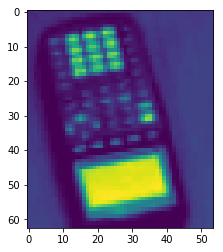

In [90]:
img1 = cv2.imread("sources/calc_image.png",0)
plt.imshow(img1)
plt.show

<font color="darkblue">**Explanation:**
<ul>
<li>First we use the imread function from the cv2 library to load the image.
<li>We use plt to add the image to a plot and show it.  The colors seem strange because the order of colors in OpenCV is different than in Python.
</ul>
</font>

Now we load one frame from the video where we want to find the calculator.

<function matplotlib.pyplot.show(*args, **kw)>

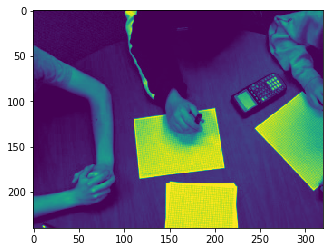

In [91]:
img2 = cv2.imread("sources/top_video_frame.jpg",0) 
plt.imshow(img2)
plt.show

Now we add a black boder to the calculator image to make it bigger (Feature finding algorithms work with bigger images)

<function matplotlib.pyplot.show(*args, **kw)>

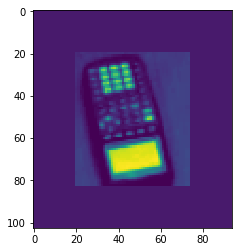

In [92]:
row, col = img1.shape[:2]
bottom = img1[row-2:row, 0:col]
mean = cv2.mean(bottom)[0]
bordersize=20
img1_border = cv2.copyMakeBorder(
    img1,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=[mean, mean, mean]
)
plt.imshow(img1_border)
plt.show

Now we run the feature extraction algorithm <a href="https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html">ORB</a> to obtain the keypoints (features and their descriptions) from both, the calculator image and the frame from the video.

In [93]:
orb = cv2.ORB_create()
(kps1, descs1) = orb.detectAndCompute(img1_border, None)
(kps2, descs2) = orb.detectAndCompute(img2, None)

Once we have the salient features from both images, we use a Brute Force matcher (BFMatcher) to find features that are similar in both images.  This algorithm use a K-Means clustering algorithm to find pairs of similar features.

In [94]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(descs1,descs2, k=2)    

Now we select only good matches, that is points that are very similar to eliminat spurious pairs.

In [95]:
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append([m])

Now we visualize the matches between both images.

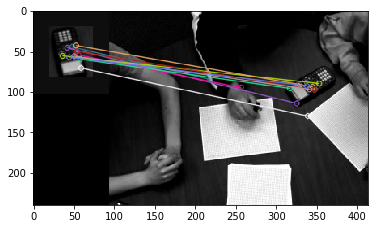

In [96]:
img3 = cv2.drawMatchesKnn(img1_border, kps1, img2, kps2, good[1:20], None, flags=2)
plt.imshow(img3)
plt.show()

Now that we have found the calculator in the video frame, we will try to infer which student is using it. For this we will follow this procedure:

* Calculate how much the image has been rotated from the original, to the one found in the frame (Rotation Matriz)
* From the rotation matriz, we calculate the angle at which the botton of the calculator is pointing.
* We send a line from the middle of the calcultor, using that angle to find out where it intersect the border of the frame
* Depending on where this line intersect, we infer which student has the calculator in that frame.

Lets start finding the <a href="https://en.wikipedia.org/wiki/Rotation_matrix">Rotation Matrix</a>

In [97]:
src_pts = np.float32([ kps1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kps2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask =cv2.estimateAffine2D(src_pts, dst_pts)
newrow = [0,0,1]
M = np.vstack([M, newrow])

print(M)

[[  0.29934759  -0.91533287 283.53595693]
 [  0.76068872   0.33056067  40.19618284]
 [  0.           0.           1.        ]]


<font color="darkblue">**Explanation:**
<ul>
<li>First, we obtain the matched points from the original image and the video frame.
<li>We use the estimate affine transform in 2D function from OpenCV (estimateAffine2D).  This function receive the corresponding points in the two images and return the rotation matrix (in 2D)
<li>Because most OpenCV functions work in 3D, we add a row to the matrix indicating that the images has not rotated around the Z axis.
<li>We can see the 3x3 matrix that describe a rotation in 3D.
</ul>
</font>

With the rotation matrix, now we can draw a border that map the original image into the frame (used only to help us understand)

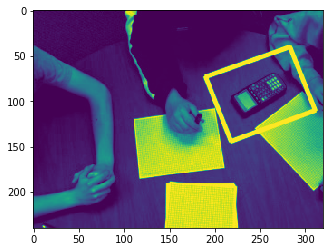

In [98]:
h,w = img1_border.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

plt.imshow(img2)
plt.show()

<font color="darkblue">**Explanation:**
<ul>
<li>First, we extract the coordinates of the borders of the calculator image.
<li>Then we use the perspectiveTransform function to calculate the corresponding points in the video frame image.
<li>Finally, we draw a rectangle with those points over the video frame image and show it.
</ul>
</font>

Now, with the calculate the angle of rotation.  For that we calculate the angle at which one of the sides of the drawn rectangles lies.  By trigonometry, it is the arctangent of the variation of y over the variation of x.

Because in the original image the calculator is not vertical, we add 10 degrees of correction to the obtained angle.

In [99]:
angleCorrection=10
dx= dst[0][0][0]-dst[1][0][0]
dy= dst[0][0][1]-dst[1][0][1]
angle=math.degrees(-math.atan2(dy, dx))
angle=angle+angleCorrection

Now we will draw the line from the center of the calculator to the border of the video to calculate its interception.  

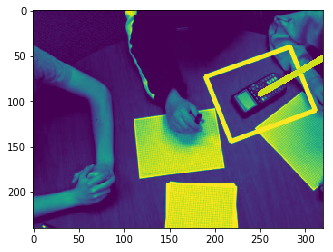

In [100]:
centerx = (dst[0][0][0]+dst[2][0][0])/2
centery = (dst[0][0][1]+dst[2][0][1])/2

x = centerx
y = centery

height,width = img2.shape[0],img2.shape[1]
n = (centery) - (math.tan(math.radians(angle)) * (width-centerx))
x0=(-n)/math.tan(math.radians(angle))

cv2.line(img2, (np.int32(centerx),np.int32(centery)), (np.int32(width-x0),0), (237,19,19),5)

plt.imshow(img2)
plt.show()

Now we use the value of x0 (the x coordinate of the intersect with the border of the frame) to find to which student the calculator is pointing at.

In [101]:
student=0
if x0>-1 and x0<width+1:
    if x0<180:
        student = 1
    if x0>179 and x0<701:
        student = 2
    if x0>700:
        student = 3
else:
    if x0<0:
        student = 1
    if x0>width:
        student = 3

print("The calculator is being used by Student",student)

The calculator is being used by Student 1


If we want to run this algorithm over all the video, we just need to read each frame from the video and calculate the student that has the calculator in each frame.

Here is the code to do that:

In [106]:
from IPython.display import clear_output

def getStudent(img2):
    student=0
    try:
        orb = cv2.ORB_create()
        (kps1, descs1) = orb.detectAndCompute(img1_border, None)
        (kps2, descs2) = orb.detectAndCompute(img2, None)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING)
        matches = bf.knnMatch(descs1,descs2, k=2)   
        good = []
        for m,n in matches:
            if m.distance < 0.9*n.distance:
                good.append([m])
        src_pts = np.float32([ kps1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kps2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask =cv2.estimateAffine2D(src_pts, dst_pts)
        newrow = [0,0,1]
        M = np.vstack([M, newrow])
        h,w = img1_border.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        angleCorrection=10
        dx= dst[0][0][0]-dst[1][0][0]
        dy= dst[0][0][1]-dst[1][0][1]
        angle=math.degrees(-math.atan2(dy, dx))
        angle=angle+angleCorrection
        centerx = (dst[0][0][0]+dst[2][0][0])/2
        centery = (dst[0][0][1]+dst[2][0][1])/2
        x = centerx
        y = centery
        height,width = img2.shape[0],img2.shape[1]
        n = (centery) - (math.tan(math.radians(angle)) * (width-centerx))
        x0=(-n)/math.tan(math.radians(angle))
        student=0
        print(x0)
        if x0>-1 and x0<width+1:
            if x0<100:
                student = 1
            if x0>100 and x0<701:
                student = 2
            if x0>700:
                student = 3
        else:
            if x0<0:
                student = 1
            if x0>width:
                student = 3
    except:
        pass
    return student
    
    
cap = cv2.VideoCapture('sources/TOP_cam4Low.avi')
frame=0
while(cap.isOpened()):
    ret, img2 = cap.read()
    frame=frame+1
    if (frame<100):
        student=getStudent(img2)
        print("Frame:",frame," - Student:",student)
        plt.imshow(img2)
        plt.show()
        clear_output(wait=True)
    else:
        break


## Identifying Facial Expression

Another common task in video is identifying facial expressions.  For this we will use a service provided by Micorsoft Cognitive API, a cloud service that analyze the image and return their analysis.

First we will load the libraries and load the file.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


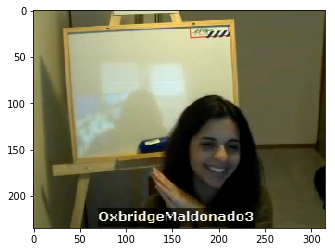

In [116]:
import requests
import json
import operator

pathToFileInDisk = "sources/frame2.png"
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()

data8uint = np.fromstring( data, np.uint8 ) 
img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

Now we will set up the API Call.  We need to create a subscription key at <a href="https://azure.microsoft.com/en-us/services/cognitive-services/">Microsfot Cognitive Services</a>.  You can use my key in this tutorial, but get yours if you want to use it for something else.

In [1]:
subscription_key = '262891629f5c44e7bb8dd59a01567efb'

face_api_url = 'https://eastus.api.cognitive.microsoft.com/face/v1.0/detect'

headers = {'Ocp-Apim-Subscription-Key': subscription_key, 'Content-Type': "application/octet-stream"}

params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'false',
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}

Now we call the service with our image and see the response.

In [2]:
response = requests.post(face_api_url, params=params, headers=headers, data=data, json={})
print(json.dumps(response.json(),indent=2))

NameError: name 'requests' is not defined

As you can see in the response, there is a lot of features extracted from the image, for example that the person seems to be a woman with black hair, without glasses and 21 years old.  It also provide information about the facil expression.

We extract this information from the json response and visualize it.

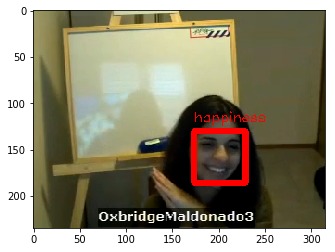

In [119]:
result = response.json()

for currFace in result:
        faceRectangle = currFace['faceRectangle']
        attributes=currFace['faceAttributes']
        emotions=attributes['emotion']
        currEmotion = max(emotions.items(), key=operator.itemgetter(1))[0]

def renderResultOnImage(faceRectangle, emotion, img ):
    faceRectangle = currFace['faceRectangle']
    cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                       (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                   color = (255,0,0), thickness = 5 )

    textToWrite = "%s" % ( emotion )
    cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )
        
renderResultOnImage( result, currEmotion, img )

plt.imshow(img)
plt.show()

# Analyzing Digital Pen Data

<a href="https://www.neosmartpen.com/en/?noredirect=en_US">Digital pens</a> has been created to capture annotations made into paper.  We can use this devices to capture what the students are writting.

Usually they export their data into an XML format that we need to read and interpret.

First, we will load the required libraries

In [120]:
%matplotlib inline
import math
import xml.etree.ElementTree as etree 
from pylab import *

Then we read the data from the xml file.  The structure of the data is:
* A note (or page) has traces (strokes made with the pen)
* A stroke is made of points (positions of the pen at given moments)
* Each point has information about the x,y position of the pen in the paper, the timestamp at which it was recorded and the presure that the user is applying to the pen.

In [122]:
page=[]
traces=[]
treeNote = etree.parse("sources/dataPen.xml")
rootNote = treeNote.getroot()
noteinfo = rootNote[0]
for trace in noteinfo:
    tracedata=[]
    for point in trace:
        pointdata={}
        pointdata["x"] = float(point[0].text)
        pointdata["y"] = float(point[1].text)
        pointdata["timestamp"] = long(point[2].text)
        pointdata["force"] = float(point[3].text)
        tracedata.append(pointdata)
    traces.append(tracedata)
    page.append(tracedata)

Now we can plot all of these traces or strokes.

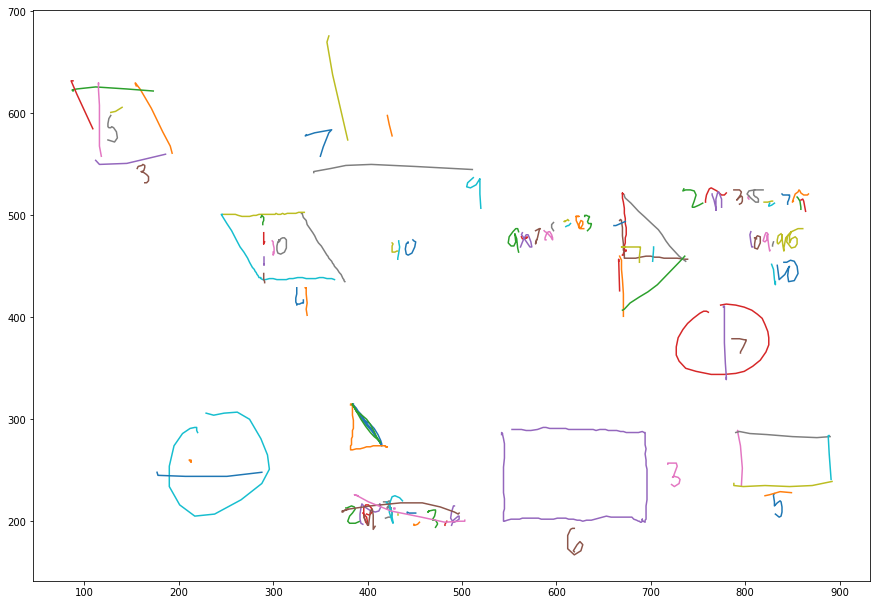

In [124]:
figure(figsize=(10*1.5,7*1.5))
for trace in page:
    x =[]
    y=[]
    for point in trace:
        x.append(int(point.get("x")))
        y.append(int(point.get("y")))
    plot(y,x)
show()

As we can see, we can obtain what the student was writing and drawing during the session.

While we can apply sketch recognition or handwriting recognition, this time we will only obtain basic writing mechanics features:

In [127]:
totalStrokes= len(traces)
totalPathLength = 0
totalNumPoints = 0
totalLength = 0
totalAveragePreasure = 0
totalTime = 0

def distance(x1,y1,x2,y2):
    xdistance=x2-x1
    ydistance=y2-y1
    return math.sqrt(xdistance*xdistance+ydistance*ydistance)


for trace in traces:
    totalNumPoints =  totalNumPoints+ len(trace)
    
    firstpoint = trace[0]
    lastpoint = trace[len(trace)-1]
    
    totalLength = totalLength + distance(firstpoint.get("x"),firstpoint.get("y"),lastpoint.get("x"),lastpoint.get("y"))
    
    pathLength =0
    for i in range (0,len(trace)-2):
        currentpoint=trace[i]
        nextpoint=trace[i+1]
        pathLength= pathLength+ distance(currentpoint.get("x"),currentpoint.get("y"),nextpoint.get("x"),nextpoint.get("y"))
    totalPathLength=totalPathLength+pathLength
    
    time = 0
    totalTime=totalTime + lastpoint.get("timestamp")-firstpoint.get("timestamp")

averagePoints = totalNumPoints/float(totalStrokes)
averagePathLength = totalPathLength/float(totalStrokes)
averageLength=totalLength/float(totalStrokes)
averageTime=totalTime/float(totalStrokes)

print("Total Strokes:",totalStrokes)
print("Total Number of Points:",totalNumPoints)
print("Total Path Length:",totalPathLength)
print("Total Length:",totalLength)
print("Total Time:",totalTime)
print("Average Number of Points per Stroke:",averagePoints)
print("Average Path Length per Stroke:",averagePathLength)
print("Average Length per Stroke:",averageLength)
print("Average Time per Stroke:",averageTime)

Total Strokes: 101
Total Number of Points: 1414
Total Path Length: 4896.955078596082
Total Length: 3122.866613316869
Total Time: 35513
Average Number of Points per Stroke: 14.0
Average Path Length per Stroke: 48.48470374847606
Average Length per Stroke: 30.9194714189789
Average Time per Stroke: 351.61386138613864


# Speech Recognition

From the audio, we will again use a Cloud Service, this time from Google, to extract the text out of the audio recordings of one student.

First we hear an example:

In [133]:
import IPython.display as ipd
ipd.Audio('sources/audios/sound11.wav') # load a local WAV file

Now, we read the names of all the wav files from the directory.

In [134]:
import speech_recognition as sr
import time
from os import path
from os import listdir

r = sr.Recognizer()
files=listdir("sources/audios")
for file in files:
    if not "sound" in file:
         files.remove(file)
print(files)

['sound9.wav', 'sound6.wav', 'sound25.wav', 'sound5.wav', 'sound20.wav', 'sound27.wav', 'sound22.wav', 'sound19.wav', 'sound8.wav', 'sound16.wav', 'sound30.wav', 'sound18.wav', 'sound24.wav', 'sound3.wav', 'sound21.wav', 'sound4.wav', 'sound17.wav', 'sound13.wav', 'sound12.wav', 'sound29.wav', 'sound32.wav', 'sound1.wav', 'sound10.wav', 'sound14.wav', 'sound26.wav', 'sound23.wav', 'sound11.wav', 'sound7.wav', 'sound28.wav', 'sound2.wav', 'sound15.wav', 'sound31.wav']


Now, for each file, we send it to google and wait for the response.  Once we get it we print it.

In [135]:
for file in files:
    AUDIO_FILE = "sources/audios/"+file
    with sr.AudioFile(AUDIO_FILE) as source:
        audio = r.record(source) 
    print("---------------------------")
    print("File:",AUDIO_FILE)
    try:
        text = r.recognize_google(audio)
        print("Audio recognized")
        print("Recognized text:", text)
    except sr.UnknownValueError:
        print("Audio not understood")
    except sr.RequestError as e:
        print("Error with service; {0}".format(e))
    time.sleep(10)

---------------------------
File: sources/audios/sound9.wav
Audio not understood
---------------------------
File: sources/audios/sound6.wav
Audio recognized
Recognized text: 149 times
---------------------------
File: sources/audios/sound25.wav
Audio recognized
Recognized text: love is never okay
---------------------------
File: sources/audios/sound5.wav
Audio recognized
Recognized text: so the bass
---------------------------
File: sources/audios/sound20.wav
Audio not understood
---------------------------
File: sources/audios/sound27.wav
Audio recognized
Recognized text: hey attention
---------------------------
File: sources/audios/sound22.wav
Audio not understood
---------------------------
File: sources/audios/sound19.wav
Audio recognized
Recognized text: X
---------------------------
File: sources/audios/sound8.wav
Audio recognized
Recognized text: yes
---------------------------
File: sources/audios/sound16.wav
Audio not understood
---------------------------
File: sources/aud

AttributeError: 'builtin_function_or_method' object has no attribute 'close'